In [1]:
import pandas as pd
import sqlite3

df_Fact = pd.read_csv('/content/bank_transactions.csv')

In [2]:
conn = sqlite3.connect("RFMdb1")
cur = conn.cursor()

In [3]:
null_counts = df_Fact.isnull().sum()
total_null_count = null_counts.sum()

print(f"Total number of null values: {total_null_count}")

Total number of null values: 7017


In [4]:
# load CRM data into the RFMdb database
# df_Fact.to_sql("data", conn)

# Drop the existing 'data' table if it exists
cur.execute("DROP TABLE IF EXISTS data")
conn.commit()

# Recreate it from the DataFrame
df_Fact.to_sql("data", conn, index=False)

1048567

In [5]:
df_Fact1 = pd.read_sql('SELECT * FROM data', conn)
df_Fact1

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/1994,F,JAMSHEDPUR,17819.05,2/8/2016,143207,25.0
1,T2,C2142763,4/4/1957,M,JHAJJAR,2270.69,2/8/2016,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/2016,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/2016,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/2016,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/1990,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


In [6]:
cur.execute("""
    DELETE FROM data
    WHERE CustomerID IS NULL
       OR CustGender IS NULL
       OR CustLocation IS NULL
       OR CustomerDOB IS NULL
       OR CustAccountBalance IS NULL
       OR TransactionDate IS NULL
       OR "TransactionAmount (INR)" IS NULL
""")
conn.commit()

df_Fact1 = pd.read_sql('SELECT * FROM data', conn)
print(df_Fact1.isnull().sum())

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


In [7]:
cur.execute('''
    DELETE FROM data
    WHERE "TransactionAmount (INR)" <= 0
''')

conn.commit()

cur.execute('''
    SELECT MIN("TransactionAmount (INR)"), MAX("TransactionAmount (INR)")
    FROM data
''')

min_value, max_value = cur.fetchone()

print(f"Minimum Transaction Amount: {min_value}")
print(f"Maximum Transaction Amount: {max_value}")

Minimum Transaction Amount: 0.01
Maximum Transaction Amount: 1560034.99


In [8]:
from datetime import datetime
import sqlite3

def calculate_age(birthdate):
    try:
        birthdate_parts = birthdate.split('/')
        day = int(birthdate_parts[0])
        month = int(birthdate_parts[1])
        year = int(birthdate_parts[2])

        if year < 100:
            year += 1900

        birthdate = datetime(year, month, day)
        today = datetime.today()

        age = today.year - birthdate.year
        if today.month < birthdate.month or (today.month == birthdate.month and today.day < birthdate.day):
            age -= 1

        return age
    except ValueError:
        return None

cur.execute("ALTER TABLE data ADD COLUMN CustomerAge INTEGER")

cur.execute("SELECT CustomerDOB, ROWID FROM data")
dob_records = cur.fetchall()

for dob_record in dob_records:
    dob, rowid = dob_record
    age = calculate_age(dob)

    if age is not None:
        cur.execute("UPDATE data SET CustomerAge = ? WHERE ROWID = ?", (age, rowid))

conn.commit()

print("Customer ages updated successfully!")

Customer ages updated successfully!


In [9]:
df_Fact1 = pd.read_sql('SELECT * FROM data', conn)
df_Fact1

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,T1,C5841053,10/1/1994,F,JAMSHEDPUR,17819.05,2/8/2016,143207,25.0,31
1,T2,C2142763,4/4/1957,M,JHAJJAR,2270.69,2/8/2016,141858,27999.0,68
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/2016,142712,459.0,28
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/2016,142714,2060.0,51
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/2016,181156,1762.5,37
...,...,...,...,...,...,...,...,...,...,...
1040789,T1048563,C8020229,8/4/1990,M,NEW DELHI,7635.19,18/9/16,184824,799.0,35
1040790,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0,33
1040791,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0,35
1040792,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0,46


In [10]:
cur.execute("""
    DELETE FROM data
    WHERE CustomerAge < 18 OR CustomerAge > 100
""")

conn.commit()

df_Fact1 = pd.read_sql('SELECT * FROM data', conn)
df_Fact1

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,T1,C5841053,10/1/1994,F,JAMSHEDPUR,17819.05,2/8/2016,143207,25.0,31
1,T2,C2142763,4/4/1957,M,JHAJJAR,2270.69,2/8/2016,141858,27999.0,68
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/2016,142712,459.0,28
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/2016,142714,2060.0,51
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/2016,181156,1762.5,37
...,...,...,...,...,...,...,...,...,...,...
983964,T1048563,C8020229,8/4/1990,M,NEW DELHI,7635.19,18/9/16,184824,799.0,35
983965,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0,33
983966,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0,35
983967,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0,46


In [11]:
top_locations = df_Fact1['CustLocation'].value_counts().head(5)
top_locations

,count
CustLocation,
MUMBAI,97523
BANGALORE,77667
NEW DELHI,76185
GURGAON,70432
DELHI,67211


In [12]:
# df_Fact1['TransactionDate'] = df_Fact1['TransactionDate_Copy']
# df_Fact1['CustomerDOB'] = df_Fact1['CustomerDOB_Copy']

In [13]:
import pandas as pd
import numpy as np

# Backup original column
df_Fact1['TransactionDate_Copy'] = df_Fact1['TransactionDate']


# First, convert to string
df_Fact1['TransactionDate'] = df_Fact1['TransactionDate'].astype(str)

# Now apply the mask to detect 4-digit years at the end
mask_4digit = df_Fact1['TransactionDate'].str.contains(r'\d{4}$', na=False)

# Parse 4-digit year dates
df_Fact1.loc[mask_4digit, 'TransactionDate'] = pd.to_datetime(
    df_Fact1.loc[mask_4digit, 'TransactionDate'],
    format='%d/%m/%Y',
    errors='coerce'
)

# Parse 2-digit year dates
df_Fact1.loc[~mask_4digit, 'TransactionDate'] = pd.to_datetime(
    df_Fact1.loc[~mask_4digit, 'TransactionDate'],
    format='%d/%m/%y',
    errors='coerce'
)


df_Fact1

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,TransactionDate_Copy
0,T1,C5841053,10/1/1994,F,JAMSHEDPUR,17819.05,2016-08-02 00:00:00,143207,25.0,31,2/8/2016
1,T2,C2142763,4/4/1957,M,JHAJJAR,2270.69,2016-08-02 00:00:00,141858,27999.0,68,2/8/2016
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2016-08-02 00:00:00,142712,459.0,28,2/8/2016
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2016-08-02 00:00:00,142714,2060.0,51,2/8/2016
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2016-08-02 00:00:00,181156,1762.5,37,2/8/2016
...,...,...,...,...,...,...,...,...,...,...,...
983964,T1048563,C8020229,8/4/1990,M,NEW DELHI,7635.19,2016-09-18 00:00:00,184824,799.0,35,18/9/16
983965,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,2016-09-18 00:00:00,183734,460.0,33,18/9/16
983966,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,2016-09-18 00:00:00,183313,770.0,35,18/9/16
983967,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,2016-09-18 00:00:00,184706,1000.0,46,18/9/16


In [14]:
df_Fact1['CustomerDOB_Copy'] = df_Fact1['CustomerDOB']

# First, convert to string
df_Fact1['CustomerDOB'] = df_Fact1['CustomerDOB'].astype(str)

# Now apply the mask to detect 4-digit years at the end
mask_4digit = df_Fact1['CustomerDOB'].str.contains(r'\d{4}$', na=False)

# Parse 4-digit year dates
df_Fact1.loc[mask_4digit, 'CustomerDOB'] = pd.to_datetime(
    df_Fact1.loc[mask_4digit, 'CustomerDOB'],
    format='%d/%m/%Y',
    errors='coerce'
)

# Parse 2-digit year dates
df_Fact1.loc[~mask_4digit, 'CustomerDOB'] = pd.to_datetime(
    df_Fact1.loc[~mask_4digit, 'CustomerDOB'],
    format='%d/%m/%y',
    errors='coerce'
)
df_Fact1

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,TransactionDate_Copy,CustomerDOB_Copy
0,T1,C5841053,1994-01-10 00:00:00,F,JAMSHEDPUR,17819.05,2016-08-02 00:00:00,143207,25.0,31,2/8/2016,10/1/1994
1,T2,C2142763,1957-04-04 00:00:00,M,JHAJJAR,2270.69,2016-08-02 00:00:00,141858,27999.0,68,2/8/2016,4/4/1957
2,T3,C4417068,1996-11-26 00:00:00,F,MUMBAI,17874.44,2016-08-02 00:00:00,142712,459.0,28,2/8/2016,26/11/96
3,T4,C5342380,1973-09-14 00:00:00,F,MUMBAI,866503.21,2016-08-02 00:00:00,142714,2060.0,51,2/8/2016,14/9/73
4,T5,C9031234,1988-03-24 00:00:00,F,NAVI MUMBAI,6714.43,2016-08-02 00:00:00,181156,1762.5,37,2/8/2016,24/3/88
...,...,...,...,...,...,...,...,...,...,...,...,...
983964,T1048563,C8020229,1990-04-08 00:00:00,M,NEW DELHI,7635.19,2016-09-18 00:00:00,184824,799.0,35,18/9/16,8/4/1990
983965,T1048564,C6459278,1992-02-20 00:00:00,M,NASHIK,27311.42,2016-09-18 00:00:00,183734,460.0,33,18/9/16,20/2/92
983966,T1048565,C6412354,1989-05-18 00:00:00,M,HYDERABAD,221757.06,2016-09-18 00:00:00,183313,770.0,35,18/9/16,18/5/89
983967,T1048566,C6420483,1978-08-30 00:00:00,M,VISAKHAPATNAM,10117.87,2016-09-18 00:00:00,184706,1000.0,46,18/9/16,30/8/78


In [15]:
# Step 1: Convert to datetime (flexibly handles both 2-digit and 4-digit years)
df_Fact1['CustomerDOB'] = pd.to_datetime(df_Fact1['CustomerDOB'], dayfirst=True, errors='coerce')

# Converting date to YYYY-MM-DD format
df_Fact1['CustomerDOB'] = df_Fact1['CustomerDOB'].dt.strftime('%Y-%m-%d')

# Step 1: Convert to datetime (flexibly handles both 2-digit and 4-digit years)
df_Fact1['TransactionDate'] = pd.to_datetime(df_Fact1['TransactionDate'], dayfirst=True, errors='coerce')

# Converting date to YYYY-MM-DD format
df_Fact1['TransactionDate'] = df_Fact1['TransactionDate'].dt.strftime('%Y-%m-%d')
df_Fact1

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,TransactionDate_Copy,CustomerDOB_Copy
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,31,2/8/2016,10/1/1994
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,68,2/8/2016,4/4/1957
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,28,2/8/2016,26/11/96
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,51,2/8/2016,14/9/73
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.5,37,2/8/2016,24/3/88
...,...,...,...,...,...,...,...,...,...,...,...,...
983964,T1048563,C8020229,1990-04-08,M,NEW DELHI,7635.19,2016-09-18,184824,799.0,35,18/9/16,8/4/1990
983965,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,183734,460.0,33,18/9/16,20/2/92
983966,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,183313,770.0,35,18/9/16,18/5/89
983967,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0,46,18/9/16,30/8/78


In [16]:
df_Fact1.to_sql("data", conn, if_exists='replace', index=False)

983969

In [17]:
rfm_query = """
WITH RFM_CTE AS (
    SELECT
        CustomerID,
        MAX(TransactionDate) AS LastTransactionDate,
        COUNT(*) AS Frequency,
        SUM("TransactionAmount (INR)") AS Monetary
    FROM data
    GROUP BY CustomerID
)
SELECT
    CustomerID,
    LastTransactionDate,
    CAST(JULIANDAY('now') - JULIANDAY(LastTransactionDate) AS INTEGER) AS Recency,  -- Recency as days since last transaction
    Frequency,
    Monetary
FROM RFM_CTE;
"""

df_rfm = pd.read_sql(rfm_query, conn)



In [18]:
df_rfm

,CustomerID,LastTransactionDate,Recency,Frequency,Monetary
0,C1010011,2016-09-26,3126,2,5106.0
1,C1010012,2016-08-14,3169,1,1499.0
2,C1010014,2016-08-07,3176,2,1455.0
3,C1010018,2016-09-15,3137,1,30.0
4,C1010024,2016-08-18,3165,1,5000.0
...,...,...,...,...,...
838084,C9099836,2016-08-07,3176,1,691.0
838085,C9099877,2016-09-15,3137,1,222.0
838086,C9099919,2016-08-18,3165,1,126.0
838087,C9099941,2016-08-28,3155,1,50.0


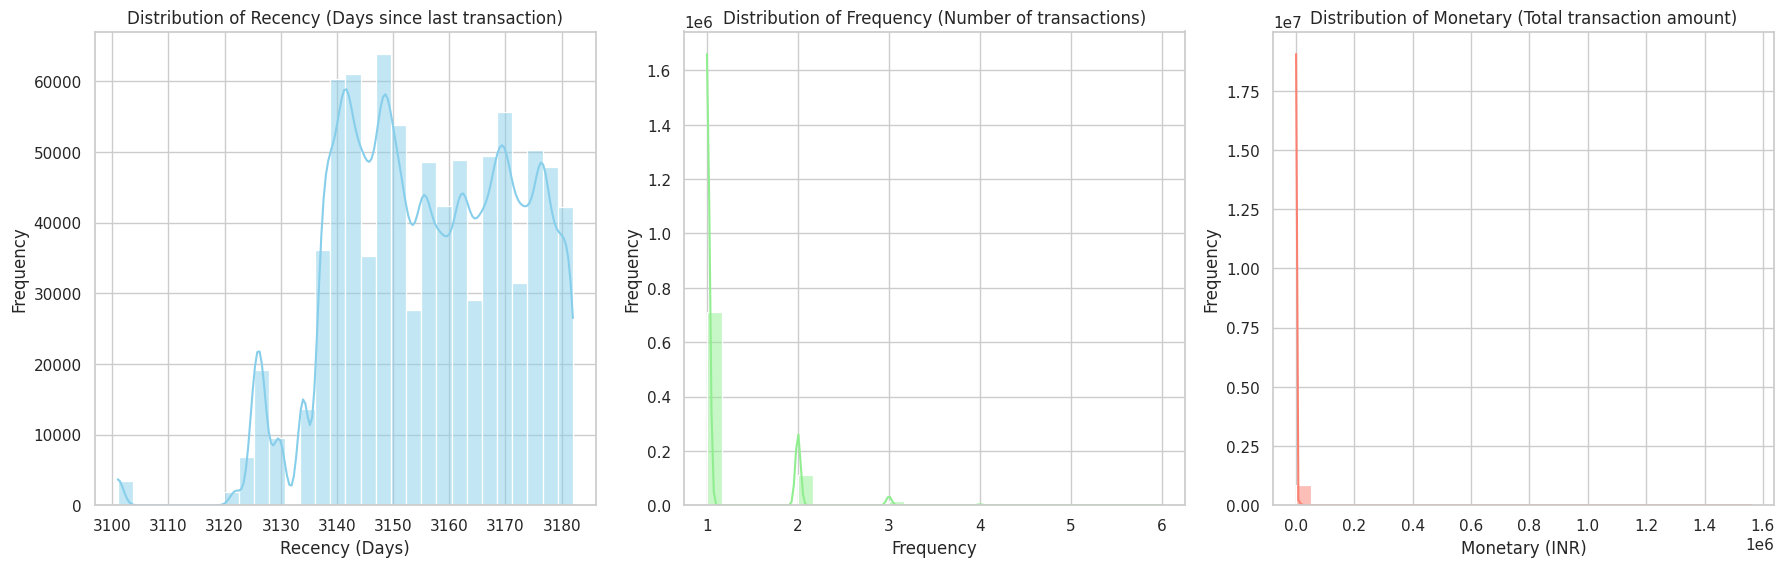

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df_rfm['Recency'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Recency (Days since last transaction)')
axes[0].set_xlabel('Recency (Days)')
axes[0].set_ylabel('Frequency')

sns.histplot(df_rfm['Frequency'], bins=30, kde=True, color='lightgreen', ax=axes[1])
axes[1].set_title('Distribution of Frequency (Number of transactions)')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Frequency')

sns.histplot(df_rfm['Monetary'], bins=30, kde=True, color='salmon', ax=axes[2])
axes[2].set_title('Distribution of Monetary (Total transaction amount)')
axes[2].set_xlabel('Monetary (INR)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [20]:
import numpy as np

df_rfm['Recency_log'] = np.log1p(df_rfm['Recency'])
df_rfm['Frequency_log'] = np.log1p(df_rfm['Frequency'])
df_rfm['Monetary_log'] = np.log1p(df_rfm['Monetary'])

df_rfm['Recency_log'] = df_rfm['Recency_log'].apply(lambda x: f"{x:.2f}")
df_rfm['Frequency_log'] = df_rfm['Frequency_log'].apply(lambda x: f"{x:.2f}")
df_rfm['Monetary_log'] = df_rfm['Monetary_log'].apply(lambda x: f"{x:.2f}")

print(df_rfm[['Recency_log', 'Frequency_log', 'Monetary_log']].head(10))

  Recency_log Frequency_log Monetary_log
0        8.05          1.10         8.54
1        8.06          0.69         7.31
2        8.06          1.10         7.28
3        8.05          0.69         3.43
4        8.06          0.69         8.52
5        8.06          0.69         6.32
6        8.06          1.10         7.53
7        8.06          1.10         6.62
8        8.06          0.69         5.34
9        8.06          0.69         9.89


In [21]:
# K-Means Implementation

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [23]:
# Convert log-transformed RFM columns to float
rfm_log = df_rfm[['Recency_log', 'Frequency_log', 'Monetary_log']].astype(float)


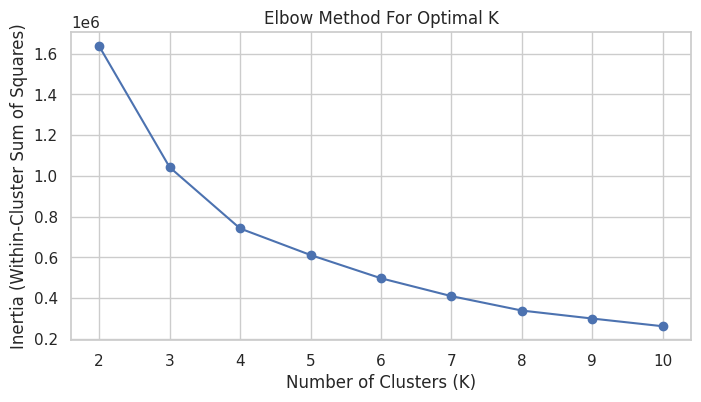

In [24]:
# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Elbow Method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()

In [25]:
# Apply KMeans with optimal K
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze clusters
cluster_profile = df_rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
cluster_profile

,Recency,Frequency,Monetary
Cluster,,,
0,3148.64,2.13,3086.12
1,3165.98,1.00,2722.21
2,3165.48,1.00,151.09
3,3139.81,1.00,1286.57


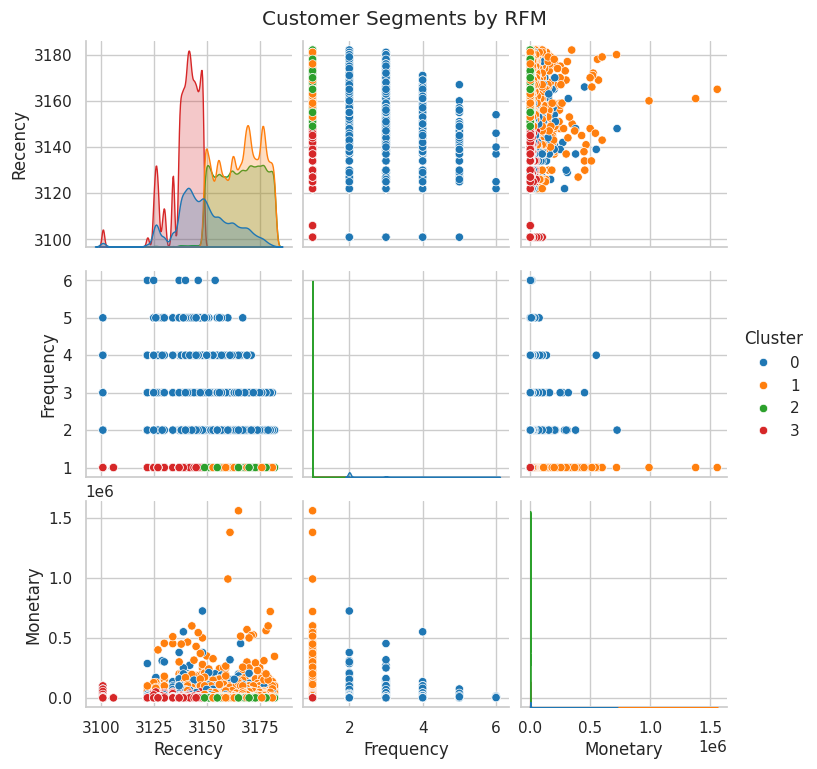

In [26]:
import seaborn as sns

sns.pairplot(df_rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='tab10')
plt.suptitle('Customer Segments by RFM', y=1.02)
plt.show()

In [27]:
#cluster profiles
for cluster_id in range(optimal_k):
    print(f"Cluster {cluster_id}:")
    print(cluster_profile.loc[cluster_id])
    print("\n")

Cluster 0:
Recency      3148.64
Frequency       2.13
Monetary     3086.12
Name: 0, dtype: float64


Cluster 1:
Recency      3165.98
Frequency       1.00
Monetary     2722.21
Name: 1, dtype: float64


Cluster 2:
Recency      3165.48
Frequency       1.00
Monetary      151.09
Name: 2, dtype: float64


Cluster 3:
Recency      3139.81
Frequency       1.00
Monetary     1286.57
Name: 3, dtype: float64


